In [1]:
import dataset_utils as dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.preprocessing import StandardScaler

#column_names = ['ID', 
#                'INPUT_1', 'INPUT_2', 'INPUT_3', 'INPUT_4', 'INPUT_5', 'INPUT_6', 'INPUT_7', 'INPUT_8', 'INPUT_9', 'INPUT_10',
#                'TARGET_x', 'TARGET_y', 'TARGET_z']
#dataframe = pd.read_csv("../data/ML-CUP23-TR.csv", sep=',', comment='#', names=column_names, index_col= 'ID')
#dataframe.head()

dev_data = dataset.load_dataset("../data/ML-CUP23-TR.csv")
test_data = dataset.load_dataset("../data/ML-CUP23-TS.csv")

# arange the dataset into inputs and labels
from dataset_utils import skl_arange_dataset

X_dev, y_dev, X_test, train_folds, val_folds = skl_arange_dataset(dev_data, test_data, scaler=StandardScaler(), folds=5)

# NeuralNet with Torch

In [3]:
import torch as t
from torch.utils.data import DataLoader
from ML_cup.dataset_utils import CupDataset
from ML_cup.pytorch import *

# Split the dev data into train and validation with k-fold cross validation and minibatch
train_loaders, val_loaders = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=32)

In [4]:
parameters = [
    {'optimizer': 'Adam', 'lr': [0.001, 0.0005, 0.0001], 'weight_decay': [0.0, 0.0001, 0.0005]},
    {'optimizer': 'SGD', 'lr': [0.01, 0.001, 0.0001], 'weight_decay': [0.0, 0.001, 0.0005], 'momentum': [0.9, 0.75],
     'nesterov': [True, False]}
]

In [5]:
lr_scheduler_params = {'mode': 'min', 'factor': 0.75, 'patience': 5, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-6}

In [6]:
# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)


New Best Parameters: {'lr': 0.001, 'weight_decay': 0.0, 'optimizer': 'Adam'},Train Loss: 1.5790822277069092, Val Loss: 1.7854856252670288
New Best Parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'optimizer': 'Adam'},Train Loss: 1.57512291431427, Val Loss: 1.7436269657952448
New Best Parameters: {'lr': 0.001, 'weight_decay': 0.0005, 'optimizer': 'Adam'},Train Loss: 1.526120780944824, Val Loss: 1.7229763065065657
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.8023837599754333, Val Loss: 1.029107589381082
Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}, Train Loss: 0.8023837599754333, Val Loss: 1.029107589381082


In [7]:
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'}

Fold: 0
Train Epoch: 0 Loss: 42.5230679321289 Val Loss: 42.99762943812779
Train Epoch: 1 Loss: 40.23488540649414 Val Loss: 36.52453831263951
Train Epoch: 2 Loss: 30.339356460571288 Val Loss: 27.59323992047991
Train Epoch: 3 Loss: 25.303926315307617 Val Loss: 21.54207502092634
Train Epoch: 4 Loss: 13.585303173065185 Val Loss: 8.103151798248291
Train Epoch: 5 Loss: 8.061449813842774 Val Loss: 7.906452860151019
Train Epoch: 6 Loss: 6.8372447967529295 Val Loss: 6.100265979766846
Train Epoch: 7 Loss: 6.150115165710449 Val Loss: 5.687727928161621
Train Epoch: 8 Loss: 5.483659839630127 Val Loss: 6.214503424508231
Train Epoch: 9 Loss: 5.457449111938477 Val Loss: 4.456516776766096
Train Epoch: 10 Loss: 5.1021081161499025 Val Loss: 6.393258231026786
Train Epoch: 11 Loss: 4.774245004653931 Val Loss: 4.2205042498452325
Train Epoch: 12 Loss: 4.39469482421875 Val Loss: 3.5183589458465576
Train Epoch: 13 Loss: 4.705772027969361 Val Loss: 3.9287780693599155
Train Epoch: 14 Loss: 4.45802191734314 Val L

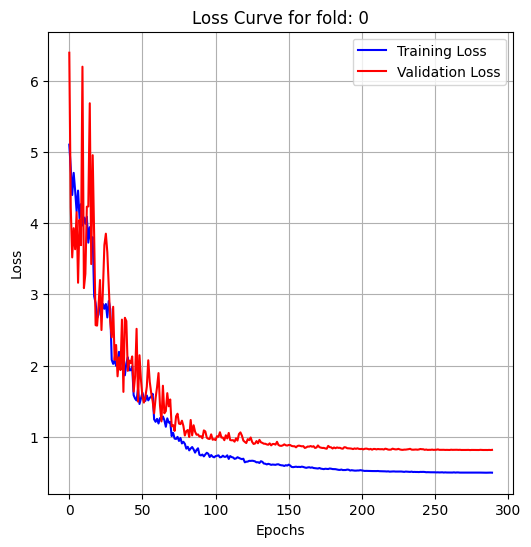

(0.4947802567481995, 0.8149599262646267)

In [9]:
# retrain the model with the best parameters
best_model = MLP()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=32)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, cooldown=3,
                                                     verbose=True, min_lr=1e-6), loss_fn= MEELoss())

In [ ]:
test_loader = DataLoader(CupDataset(test_data))

# plot twist, it's only the inputs

# Evaluate the trained model on the test set
model = best_model
model.eval()  # Set the model to evaluation mode

outputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        output = model(inputs)
        outputs.append(output)

outputs

# Keras

In [10]:
from tens_keras import *

parameters = [
    {'optimizer': 'Adam', 'learning_rate': [0.001, 0.0001, 0.00001], 'weight_decay': [0.0, 0.0001, 0.0005],
     'use_ema': [True, False]},
    {'optimizer': 'SGD', 'learning_rate': [0.01, 0.001, 0.0001], 'weight_decay': [0.0, 0.0001, 0.0005],
     'momentum': [0.9, 0.75], 'nesterov': [True, False]}
]

layer_configurations = [
    # 2 uniform hidden layers 200
    [
        ('dense', 200),
        ('dense', 200)
    ],

    # 3 uniform hidden layers 200
    [
        ('dense', 200),
        ('dense', 200),
        ('dense', 200)
    ],
    # 3 uniform hidden layers 150
    [
        ('dense', 150),
        ('dense', 150),
        ('dense', 150)
    ],
    # 3 layers with different number of neurons
    [
        ('dense', 25),
        ('dense', 50),
        ('dense', 150)
    ],
    # 3 layers with different number of neurons
    [
        ('dense', 150),
        ('dense', 50),
        ('dense', 25)
    ],
    # 3 uniform hidden layers 300
    [
        ('dense', 300),
        ('dense', 300),
        ('dense', 300)
    ],
    # 5 uniform hidden layers 150
    [
        ('dense', 150),
        ('dense', 150),
        ('dense', 150),
        ('dense', 150),
        ('dense', 150)
    ]
]

In [ ]:
best_values = (20, 20)  # impose a minimum training and validation loss to reach
best_combo = None
for layer_configuration in layer_configurations:
    print(f"Layer configuration: {layer_configuration}")
    best_keras_params, res_values = keras_grid_search(model_builder=keras_mlp, parameters=parameters,
                                                      model_layers=layer_configuration,
                                                      train_data=train_folds, val_data=val_folds, verbose=0,
                                                      best_values=best_values)
    print(f"Best parameters: {best_keras_params}, with values: {res_values}")
    if (res_values[0] < best_values[0]) and (res_values[1] < best_values[1]):
        best_values = res_values
        best_combo = (layer_configuration, best_keras_params)
    print(" ------------------------------------ ")
print(f"Best combo: {best_combo}, with values: {best_values}")

Layer configuration: [('dense', 200), ('dense', 200)]
New Best Parameters: {'learning_rate': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}, Train Loss: 5.884357261657715, Val Loss: 5.988637447357178
New Best Parameters: {'learning_rate': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'}, Train Loss: 5.8858410835266115, Val Loss: 5.987708377838135
New Best Parameters: {'learning_rate': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'}, Train Loss: 5.886114406585693, Val Loss: 5.98471851348877
Best Parameters: {'learning_rate': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'}, Train Loss: 5.886114406585693, Val Loss: 5.98471851348877
Best parameters: {'learning_rate': 0.01, 'weight_decay': 0.0001, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'}, with values: (5.886114406585693, 5.98471851348877)
 ------------------------------------ 
Layer 

# SVM

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from svm import *

from sklearn.model_selection import GridSearchCV

C_values = [0.1, 1, 10, 100, 1000]
epsilon_values = [0.1, 0.01, 0.001, 0.0001]

for C, epsilon in itertools.product(C_values, epsilon_values):
    print(f"C: {C}, epsilon: {epsilon}")
    mee = []
    for t_fold, v_fold in zip(train_folds, val_folds):
        svr = SVR(kernel='linear', C=C, epsilon = epsilon)  # SVR instance

        inputs, targets = t_fold
        # Instantiate MultiOutputRegressor with SVR as the base regressor
        mor = MultiOutputRegressor(svr)

        # Train the SVR model
        mor.fit(inputs, targets)

        val_inputs, val_targets = v_fold
        # Predict outputs for the validation set
        predictions = mor.predict(val_inputs)

        # Calculate Euclidean distances between predicted and actual points
        euclidean_distances = np.sqrt(np.sum((predictions - val_targets) ** 2, axis=1))

        # Calculate Mean Euclidean Error
        mean_euclidean_error = np.mean(euclidean_distances)
        mee.append(mean_euclidean_error)
    print(f"Mean Euclidean Error: {np.mean(mee)}")
